In [ ]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
mnist_transform=transforms.Compose([
                              transforms.Resize((28,28)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])

train_dataset = datasets.MNIST(root='./mnist_data',
                                  train=True,
                                  download=True,
                                  transform=mnist_transform)

# validation or test dataset loading
validation_dataset = datasets.MNIST(root='./mnist_data',
                                  train=False,
                                  download=True,
                                  transform=mnist_transform)

print(train_dataset)
print(validation_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True) # shuffle training data before each epoch to avoid local min
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.81MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.08MB/s]

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist_data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 30,
                              kernel_size = 5, stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(30 * 5 * 5, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 30 * 5 * 5)    # flattening, torch.Size([100 (batch), 750])  for CNN
        x = F.relu(self.fc1(x))
        x = self.fc2(x)     # activation not needed    # multi class classification -> raw output instead of softmax applied
        return x

In [ ]:
torch.manual_seed(1)
#model = NN().to(device) # model 1
model = CNN().to(device) # model 2 & 3 & 4
model

CNN(
  (conv1): Conv2d(1, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=750, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
from prettytable import PrettyTable
def count_parameters(model):
  table = PrettyTable(["Modules", "Parameters"])
  total_params = 0
  for name, parameter in model.named_parameters():
    if not parameter.requires_grad: continue
    param = parameter.numel()
    table.add_row([name, param])
    total_params+=param
  print(table)
  print('Total Trainable Params: {}'.format(total_params))
  return total_params

count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    750     |
|  conv1.bias  |     30     |
| conv2.weight |    8100    |
|  conv2.bias  |     30     |
|  fc1.weight  |   375000   |
|   fc1.bias   |    500     |
|  fc2.weight  |    5000    |
|   fc2.bias   |     10     |
+--------------+------------+
Total Trainable Params: 389420


389420

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9,  weight_decay=1e-3)

In [ ]:
epochs = 20
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

t0 = int(round(time.time()))

for eno in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0

  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in train_loader: # a batch of 100 images X 600 batches -> 60,000 for a single epoch, train_loader has 600 items
    inputs = inputs.to(device)
    labels = labels.to(device)  # use GPU

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, pred_idx = torch.max(outputs, 1)

    running_loss += loss.item()
    running_corrects += torch.sum(pred_idx == labels.data).item()

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)


        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data).item()

    epoch_loss = running_loss/len(train_loader)
    epoch_acc = running_corrects/ len(train_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    print('--------epoch :', (eno+1), '-----------------------')
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc))

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc))

print('Time elapsed {}seconds'.format(int(round(time.time())) - t0))

--------epoch : 1 -----------------------
training loss: 0.0366, acc 98.9150 
validation loss: 0.0373, validation acc 98.7300 
--------epoch : 2 -----------------------
training loss: 0.0352, acc 98.9500 
validation loss: 0.0362, validation acc 98.8000 
--------epoch : 3 -----------------------
training loss: 0.0340, acc 99.0267 
validation loss: 0.0363, validation acc 98.7600 
--------epoch : 4 -----------------------
training loss: 0.0332, acc 99.0350 
validation loss: 0.0328, validation acc 98.9400 
--------epoch : 5 -----------------------
training loss: 0.0319, acc 99.0617 
validation loss: 0.0329, validation acc 98.9800 
--------epoch : 6 -----------------------
training loss: 0.0310, acc 99.1150 
validation loss: 0.0346, validation acc 98.9000 
--------epoch : 7 -----------------------
training loss: 0.0303, acc 99.1267 
validation loss: 0.0347, validation acc 98.9000 
--------epoch : 8 -----------------------
training loss: 0.0296, acc 99.1283 
validation loss: 0.0321, validati

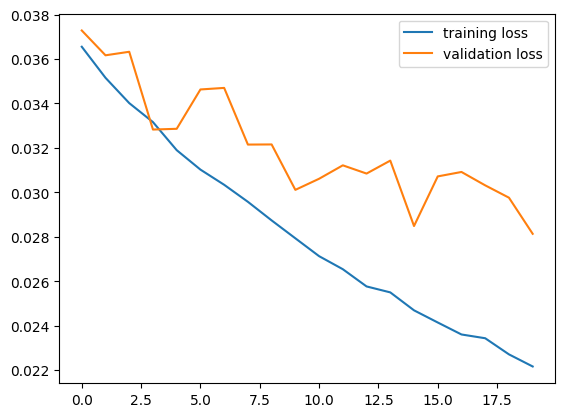

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

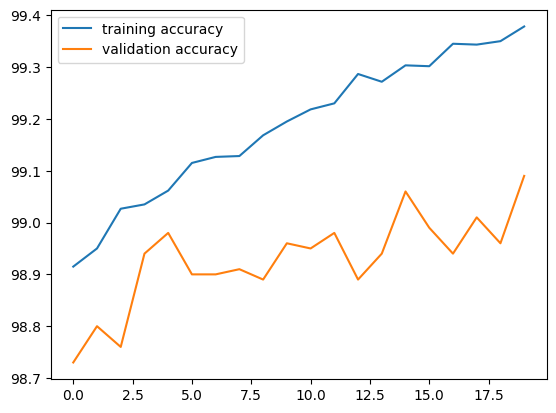

In [ ]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [ ]:
def fConvertImg(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)  # clip image intensity between min (0) & max (1)
  return image

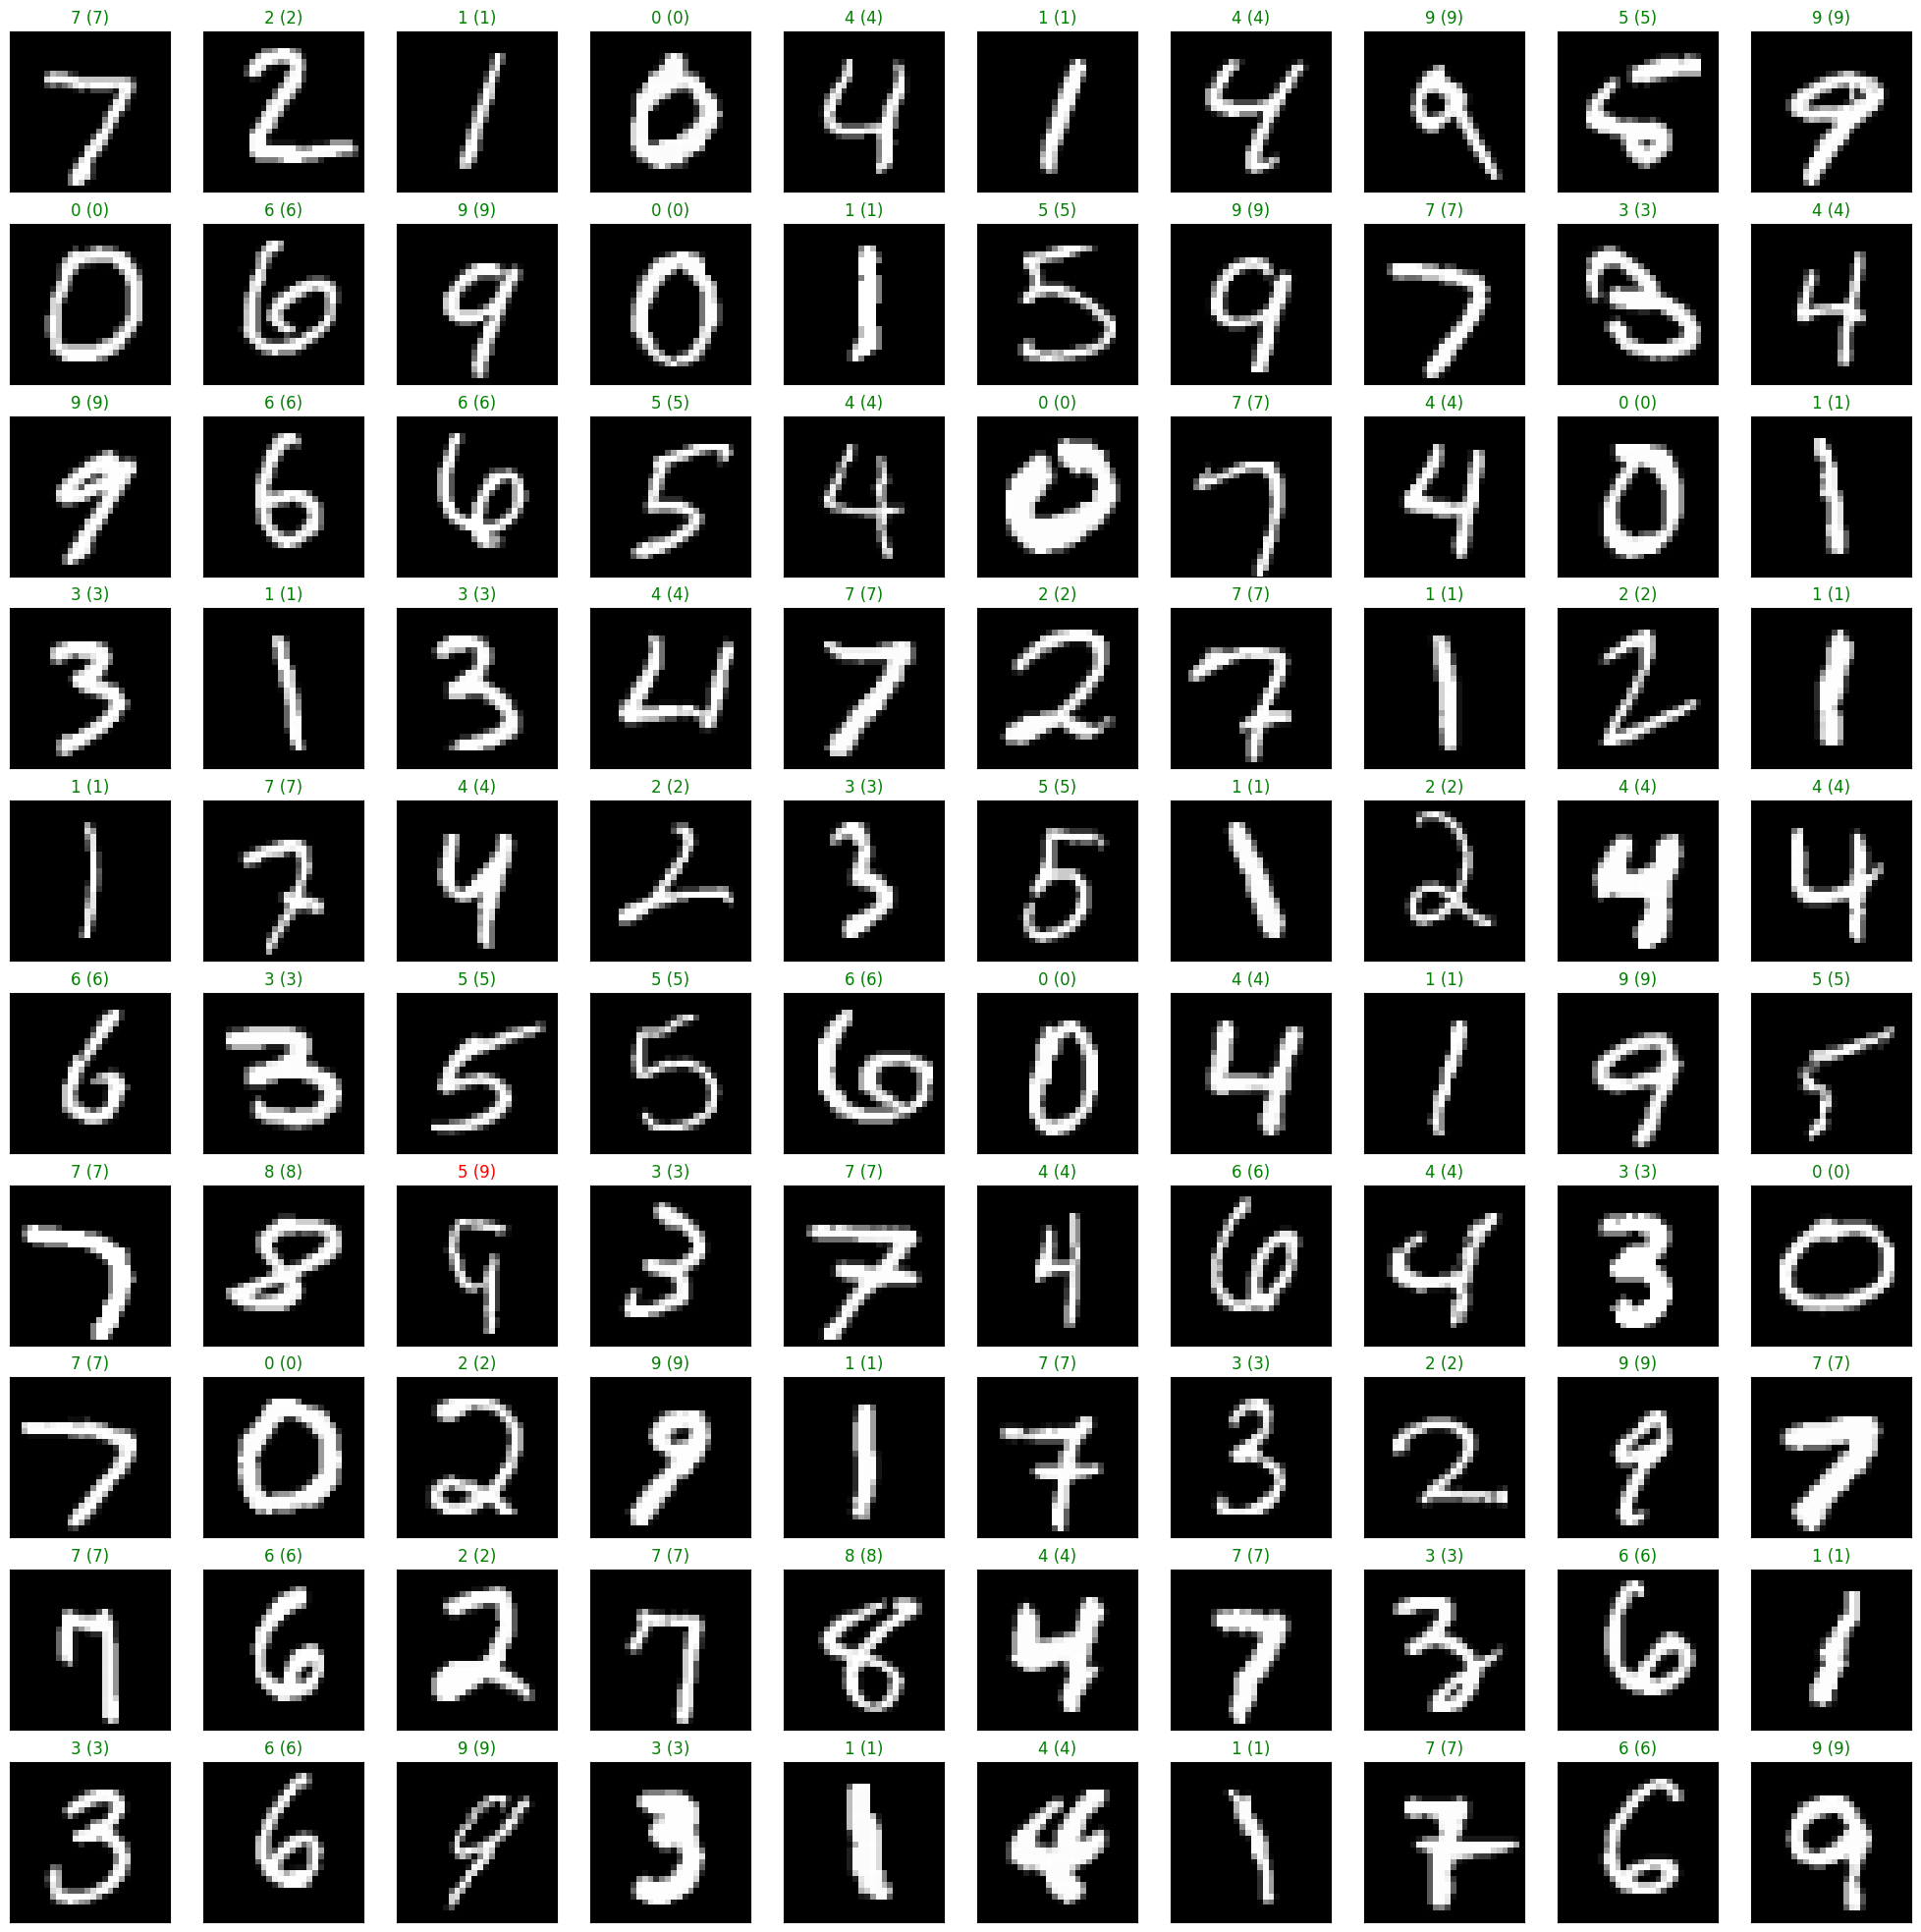

In [ ]:
dataiter = iter(validation_loader) # iter() returns an iterator for the given iterable object.
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 25))

for idx in np.arange(len(dataiter)):
  ax = fig.add_subplot(10, 10, idx+1, xticks=[], yticks=[])


  image = images[idx].cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  plt.imshow(image)

  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))